## Accessing the Impact Observatory's Biodiversity Intactness data with the Planetary Computer STAC API

Generated by [Impact Observatory](https://www.impactobservatory.com/), in collaboration with [Vizzuality](https://www.vizzuality.com/), these datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020. In this notebook, we'll demonstrate how to access and work with this data through the Planetary Computer.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. If you are using the [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) to run this notebook, then your API key is automatically set to the environment variable `PC_SDK_SUBSCRIPTION_KEY` for you when your server is started. Otherwise, you can view your keys by signing in to the [developer portal](https://planetarycomputer.developer.azure-api.net/). The API key may be manually set via the environment variable `PC_SDK_SUBSCRIPTION_KEY` or the following code:

```python
import planetary_computer
planetary_computer.settings.set_subscription_key(<YOUR API Key>)
```

In [1]:
import pandas as pd
import planetary_computer
import pystac_client
import rich.table
import stackstac
from geogif import gif

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Select a region and find STAC Items

Let's look at an area centered on the Brazilian town of Colniza.

In [4]:
bbox_of_interest = [-59.958, -9.818, -58.633, -8.946]
search = catalog.search(collections=["io-biodiversity"], bbox=bbox_of_interest)

items = list(search.items())
for item in items:
    print(item)

<Item id=bii_2020_-8.331364758881804_-65.13062798906854_cog>
<Item id=bii_2019_-8.331364758881804_-65.13062798906854_cog>
<Item id=bii_2018_-8.331364758881804_-65.13062798906854_cog>
<Item id=bii_2017_-8.331364758881804_-65.13062798906854_cog>


### Available Assets & Item Properties

Our search returned four STAC Items. We can tell from their IDs that that they contain data for the same area but for different times, specifically the years 2017 through 2020. Let's display the available assets and properties for the 2017 Item.

In [6]:
asset_table = rich.table.Table("Asset Key", "Asset Title")
for key, value in items[-1].assets.items():
    asset_table.add_row(key, value.title)
asset_table

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key        ┃ Asset Title                     ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data             │ Biodiversity Intactness         │
│ tilejson         │ TileJSON with default rendering │
│ rendered_preview │ Rendered preview                │
└──────────────────┴─────────────────────────────────┘

In [8]:
property_table = rich.table.Table("Property Name", "Property Value")
for key, value in sorted(items[-1].properties.items()):
    property_table.add_row(key, str(value))
property_table

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Property Name  ┃ Property Value                                                                                 ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ datetime       │ None                                                                                           │
│ end_datetime   │ 2017-12-31T23:59:59Z                                                                           │
│ proj:epsg      │ 4326                                                                                           │
│ proj:shape     │ [7992, 7992]                                                                                   │
│ proj:transform │ [0.0008983152841195215, 0.0, -65.13062798906854, 0.0, -0.0008983152841195215,                  │
│                │ -8.331364758881804, 0.0, 0.0, 1.0]                                                             │
│ start_datetime │ 2017-01-01T00:00:00Z                                                                           │
└────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────┘

### Load the Data and Plot

We are interested in the "data" asset. We'll use the `stackstac` library to read the data assets for the four Items into a single `xarray.DataArray`.

In [9]:
stack = (
    stackstac.stack(items, bounds_latlon=bbox_of_interest, assets=["data"])
    .assign_coords(
        time=pd.to_datetime([item.properties["start_datetime"] for item in items])
        .tz_convert(None)
        .to_numpy()
    )
    .sortby("time")
)
stack.name = "Biodiversity Intactness"
stack

<xarray.DataArray 'Biodiversity Intactness' (time: 4, band: 1, y: 972, x: 1476)>
dask.array<getitem, shape=(4, 1, 972, 1476), dtype=float64, chunksize=(1, 1, 972, 1024), chunktype=numpy.ndarray>
Coordinates: (12/15)
  * time            (time) datetime64[ns] 2017-01-01 2018-01-01 ... 2020-01-01
    id              (time) <U50 'bii_2017_-8.331364758881804_-65.130627989068...
  * band            (band) <U4 'data'
  * x               (x) float64 -59.96 -59.96 -59.96 ... -58.63 -58.63 -58.63
  * y               (y) float64 -8.945 -8.946 -8.947 ... -9.816 -9.817 -9.818
    proj:shape      object {7992}
    ...              ...
    proj:transform  object {0.0, 1.0, 0.0008983152841195215, -0.0008983152841...
    raster:bands    object {'sampling': 'area', 'data_type': 'float32', 'spat...
    title           <U23 'Biodiversity Intactness'
    description     <U54 'Terrestrial biodiversity intactness at 100m resolut...
    version         <U2 'v1'
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-59.958053638557466, -9.818586...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-59.96|\n| 0.00,-0.00,-8.95|\n| 0.00, 0.00, 1.00|
    resolution:  0.0008983152841195215

At this point we haven't loaded any data into memory yet. Let's drop the single `band` dimension and load the data by calling `.compute()`.

In [11]:
data_array = stack.squeeze().compute()

Now we can plot the data time series in a grid.

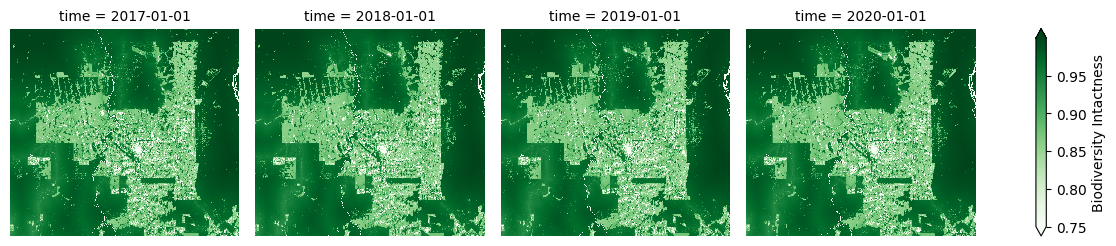

In [12]:
grid = data_array.plot(col="time", cmap="Greens", robust=True)
for ax in grid.axs.flat:
    ax.set_axis_off()

It's not easy to see the changes in a static plot, so let's make a gif that loops through the years.

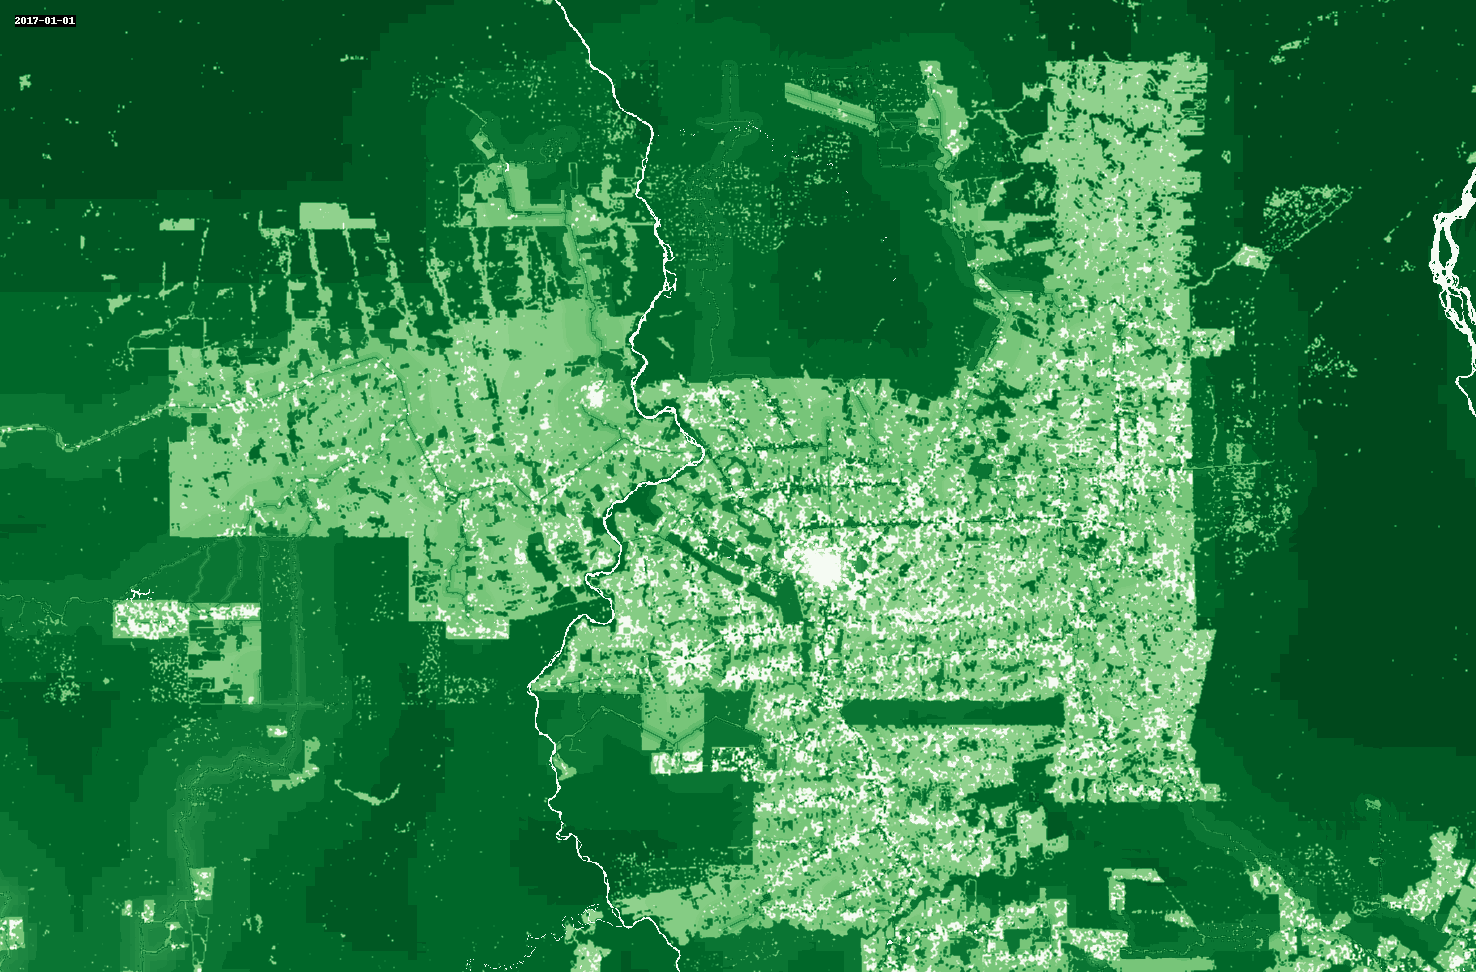

In [13]:
gif(data_array, fps=1, cmap="Greens", robust=True)